# PM2.5 prediction (without exogenous variable)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle as p

In [2]:
import matplotlib as mpl
mpl.__version__  

'3.5.1'

In [ ]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [3]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

## with sklearn

In [4]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [5]:
data = pd.read_csv("pm2.5_date_newest.csv", index_col="ACQ_DATE", parse_dates=True)

<AxesSubplot:xlabel='ACQ_DATE'>

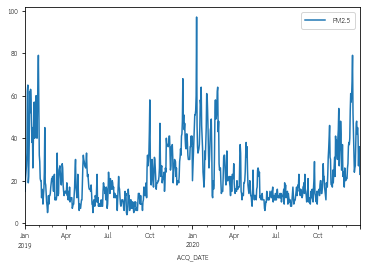

In [6]:
bangkok = data[data["CITY"] == "กรุงเทพมหานคร"][["PM2.5"]]

bangkok.plot()

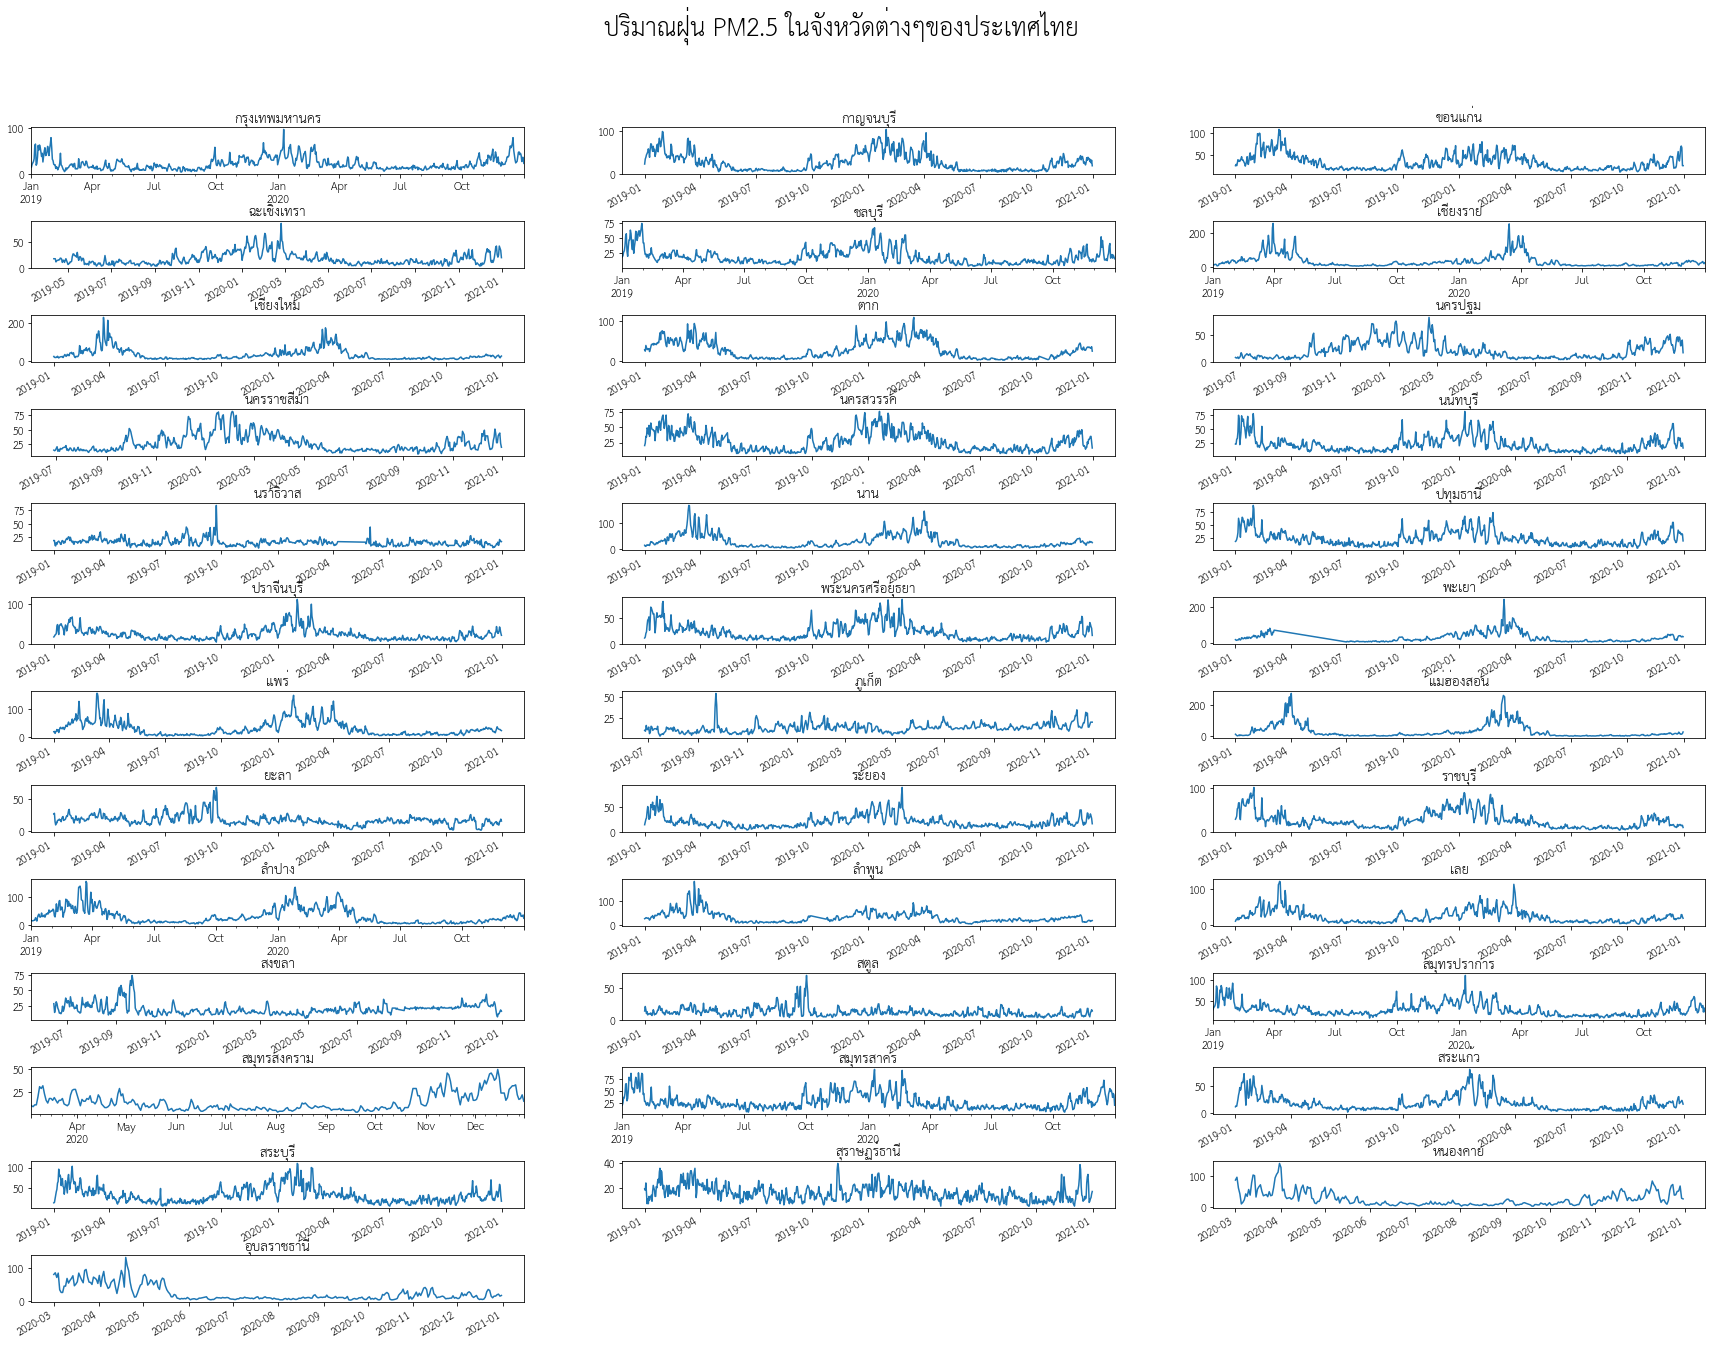

In [7]:
plt.figure(figsize=(30, 24))
plt.subplots_adjust(hspace=1)
plt.suptitle("ปริมาณฝุ่น PM2.5 ในจังหวัดต่างๆของประเทศไทย", fontsize=36, y=0.95)

for n, city in enumerate(data["CITY"].unique()):

    ax = plt.subplot(13, 3, n + 1)

    data[data["CITY"] == city]["PM2.5"].plot(ax=ax, fontsize=16)


    ax.set_title(city, fontsize=20)

    ax.set_xlabel("")


In [8]:
from random import seed, choices

seed(1234)

train_city = choices(data["CITY"].unique(),k = round(4/5 * 36))

test_city = [city for city in data["CITY"].unique() if city not in train_city]


train_city, test_city

(['หนองคาย',
  'พระนครศรีอยุธยา',
  'กรุงเทพมหานคร',
  'สระบุรี',
  'สุราษฏร์ธานี',
  'ยะลา',
  'ลำปาง',
  'ฉะเชิงเทรา',
  'สตูล',
  'นครปฐม',
  'กาญจนบุรี',
  'สมุทรปราการ',
  'นราธิวาส',
  'ราชบุรี',
  'ระยอง',
  'เชียงราย',
  'เชียงใหม่',
  'ชลบุรี',
  'กรุงเทพมหานคร',
  'แพร่',
  'หนองคาย',
  'ขอนแก่น',
  'แม่ฮ่องสอน',
  'พะเยา',
  'ระยอง',
  'ฉะเชิงเทรา',
  'ยะลา',
  'นครราชสีมา',
  'แม่ฮ่องสอน'],
 ['ตาก',
  'นครสวรรค์',
  'นนทบุรี',
  'น่าน',
  'ปทุมธานี',
  'ปราจีนบุรี',
  'ภูเก็ต',
  'ลำพูน',
  'เลย',
  'สงขลา',
  'สมุทรสงคราม',
  'สมุทรสาคร',
  'สระแก้ว',
  'อุบลราชธานี'])

In [34]:
loey = data[data["CITY"] == "เลย"][["PM2.5"]]

In [35]:
loey

,PM2.5
ACQ_DATE,
2019-01-01,11
2019-01-02,15
2019-01-03,17
2019-01-04,15
2019-01-05,21
...,...
2020-12-27,20
2020-12-28,29
2020-12-29,29


In [36]:
loey_predict = loey[['PM2.5']]
# inserting new column with yesterday's consumption values
loey_predict.loc[:,'PM2.5_Yesterday'] = loey_predict.loc[:,'PM2.5'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
loey_predict.loc[:,'PM2.5_Yesterday_Diff'] = loey_predict.loc[:,'PM2.5_Yesterday'].diff()
# dropping NAs
loey_predict = loey_predict.dropna(axis=0)

In [9]:
bangkok_predict = bangkok[['PM2.5']]
# inserting new column with yesterday's consumption values
bangkok_predict.loc[:,'PM2.5_Yesterday'] = bangkok_predict.loc[:,'PM2.5'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
bangkok_predict.loc[:,'PM2.5_Yesterday_Diff'] = bangkok_predict.loc[:,'PM2.5_Yesterday'].diff()
# dropping NAs
bangkok_predict = bangkok_predict.dropna()

In [10]:

train = bangkok_predict[:round(4/5 * len(bangkok_predict))]


valid_test = bangkok_predict[round(4/5 * len(bangkok_predict)):]


valid = valid_test[:round(1/2 * len(valid_test))]

test = valid_test[round(1/2 * len(valid_test)):]



<AxesSubplot:xlabel='ACQ_DATE'>

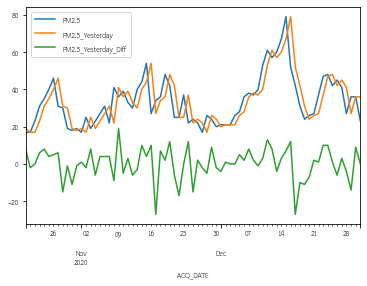

In [11]:
test.plot()

In [38]:
X_loey = loey_predict.drop(["PM2.5"], axis=1)
y_loey = loey_predict["PM2.5"]

In [12]:
X_train = train.drop(["PM2.5"], axis=1)
y_train = train["PM2.5"]
X_val = valid.drop(["PM2.5"], axis=1)
y_val = valid["PM2.5"]
X_test = test.drop(["PM2.5"], axis=1)
y_test = test["PM2.5"]

In [13]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score


from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

LR: 0.215561 (0.401513)


C:\Users\peam_ai_book\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\peam_ai_book\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\peam_ai_book\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_m

NN: 0.103804 (0.546245)
KNN: 0.041472 (0.527738)
RF: -0.283841 (0.761468)
SVR: -1.245042 (1.528526)


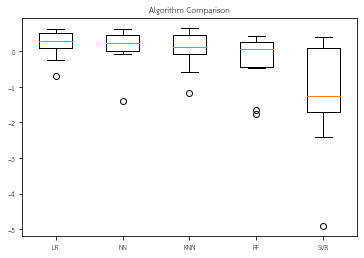

In [14]:
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [15]:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [16]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_forest_score = gsearch.best_score_
best_forest_model = gsearch.best_estimator_

In [17]:
y_true = y_val.values
y_pred = best_forest_model.predict(X_val)
regression_results(y_true, y_pred)

explained_variance:  -0.1127
mean_squared_log_error:  0.0646
r2:  -0.1288
MAE:  3.389
MSE:  19.5378
RMSE:  4.4202


In [31]:
X_test

,PM2.5_Yesterday,PM2.5_Yesterday_Diff
ACQ_DATE,,
2020-10-20,19.0,8.0
2020-10-21,17.0,-2.0
2020-10-22,17.0,0.0
2020-10-23,23.0,6.0
2020-10-24,31.0,8.0
...,...,...
2020-12-27,45.0,3.0
2020-12-28,41.0,-4.0
2020-12-29,27.0,-14.0


In [48]:
X_loey

,PM2.5_Yesterday,PM2.5_Yesterday_Diff
ACQ_DATE,,
2019-01-03,15.0,4.0
2019-01-04,17.0,2.0
2019-01-05,15.0,-2.0
2019-01-06,21.0,6.0
2019-01-07,15.0,-6.0
...,...,...
2020-12-27,19.0,0.0
2020-12-28,20.0,1.0
2020-12-29,29.0,9.0


In [49]:
y_pred_test = best_forest_model.predict(X_loey)#.drop(["Y_pred_test"], axis=1))

In [50]:
y_pred_test = pd.DataFrame({"y_pred_test":y_pred_test}, index=X_loey.index)

In [51]:
len(y_pred_test)

719

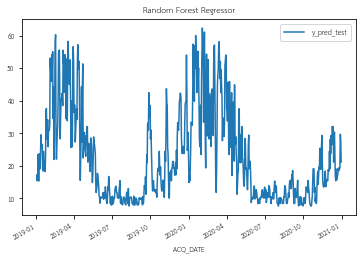

In [54]:
y_pred_test.plot()

plt.title("Random Forest Regressor")
plt.show()

<AxesSubplot:xlabel='ACQ_DATE'>

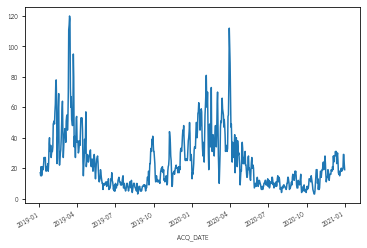

In [55]:
y_loey.plot()

In [21]:
param_list = {"hidden_layer_sizes": [(1,),(50,)], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005]}

In [22]:

model = MLPRegressor()
param_search = param_list
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_nn_score = gsearch.best_score_
best_nn_model = gsearch.best_estimator_

C:\Users\peam_ai_book\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
C:\Users\peam_ai_book\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\Users\peam_ai_book\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\peam_ai_book\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\peam_ai_book\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_tru

In [23]:
y_true = y_val.values
y_pred = best_nn_model.predict(X_val)
regression_results(y_true, y_pred)

explained_variance:  -0.033
mean_squared_log_error:  0.0607
r2:  -0.0333
MAE:  3.2327
MSE:  17.8845
RMSE:  4.229


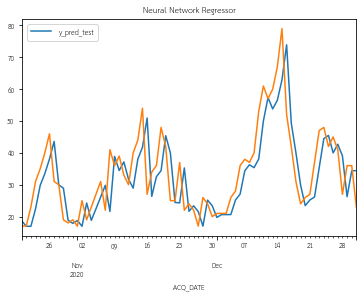

In [24]:
y_pred_test = best_nn_model.predict()#.drop(["Y_pred_test"], axis=1))
y_pred_test = pd.DataFrame({"y_pred_test":y_pred_test}, index=y_test.index)
y_pred_test.plot()
y_test.plot()
plt.title("Neural Network Regressor")
plt.show()

In [25]:
with open("best_forest_model_sklearn.pkl", "wb") as file:

    p.dump(best_forest_model, file)


with open("best_nn_model_sklearn.pkl", "wb") as file:

    p.dump(best_nn_model, file)

## with tensorflow

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, losses







In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))

    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
time = np.array(bangkok.index)

In [ ]:
time_train = time[:round(4/5 * len(time))]

X_train = bangkok[:round(4/5 * len(bangkok))]

time_val_test = time[round(4/5 * len(time)):]

X_val_test = bangkok[round(4/5 * len(bangkok)):]

time_val = time_val_test[:round(1/2 * len(time_val_test))]

X_val = X_val_test[:round(1/2 * len(X_val_test))]

time_test = time_val_test[round(1/2 * len(time_val_test)):]

X_test = X_val_test[round(1/2 * len(X_val_test)):]

In [ ]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)

val = windowed_dataset(X_val, window_size, batch_size, shuffle_buffer_size)

dnn = tf.keras.layers.Dense(1)

model = tf.keras.Sequential([tf.keras.layers.Input([window_size]),dnn])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

model.fit(dataset,epochs=100, validation_data=val)



In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[window_size]),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(filters=4, kernel_size=5, strides=1, padding="causal", activation="relu"),
    #tf.keras.layers.LSTM(1),
    tf.keras.layers.Dense(1)

])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

model.fit(dataset,epochs=100, validation_data=val)



In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[window_size]),
    #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    #tf.keras.layers.Conv1D(filters=4, kernel_size=5, strides=1, padding="causal", activation="relu"),
    #tf.keras.layers.LSTM(1),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)


])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

history = model.fit(dataset,epochs=200, validation_data=val)

In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
forecast = []
for time in range(len(X_test.values)- window_size):

    forecast.append(model.predict(X_test.values[time:time + window_size][np.newaxis]))

forecast  = np.array(forecast)[:,0,0]

In [ ]:
len(forecast)

In [ ]:
len(X_test.values)

In [ ]:
plotx = X_test.iloc[19:-1]
plotx["Predict"] = forecast

plotx.plot()
plt.legend()